# Import

In [2]:
import pandas as pd
from psaw import PushshiftAPI
import datetime as dt
from tqdm import tqdm
import numpy as np
import warnings
import analysis_util
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr

# Data

In [3]:
df=pd.read_csv('/home/pelle/Master_Thesis/data/processed/community_metrics.csv').sort_values('number_of_nodes',ascending=False)
# convert to int in days mean_delta_time
df['mean_delta_time']=df['mean_delta_time'].apply(lambda x: int(x[:3]))

# remove old versions of each subrredit
def remove_old_versions(df):
    df=df.sort_values('version')
    df=df.drop_duplicates(subset=['subreddit'],keep='last')
    return df

df=remove_old_versions(df)
df.head(20)

,subreddit,version,period,total_activity,number_of_nodes,number_of_edges,average_weight_of_edges,median_weight_of_edges,average_degree,median_degree,average_clustering_coefficient,mean_activity,mean_delta_time,number_of_reciprocal_edges,fraction_of_reciprocal_edges,clustering_coefficient_p_value
9,FourSentenceStories,2022-11-18 10:14:18,2021-05-04 - 2021-12-28,200,34,28,2.678571,1.0,1.647059,1.0,0.274683,5.823529,19,15,0.428571,0.023
10,Trump666,2022-11-18 10:15:23,2020-03-16 - 2022-01-01,6746,755,1628,2.652948,1.0,4.312583,2.0,0.202507,7.909934,53,1048,0.492944,0.000
11,GraphTheory,2022-11-18 10:18:32,2015-02-17 - 2021-12-26,497,247,163,1.717791,1.0,1.319838,1.0,0.015602,2.012146,59,124,0.563636,0.286
12,jazznoir,2022-11-18 10:19:14,2015-01-01 - 2022-01-01,4725,1497,1139,1.474100,1.0,1.521710,1.0,0.009824,2.985944,122,640,0.453258,0.016
13,indoorbouldering,2022-11-18 11:16:58,2017-08-23 - 2022-01-01,10532,2529,4866,1.665228,1.0,3.848161,2.0,0.061709,3.967181,112,3487,0.531960,0.000
14,DTU,2022-11-18 11:22:59,2015-05-15 - 2022-01-01,2788,689,1196,1.805184,1.0,3.471698,2.0,0.064316,4.046444,136,1014,0.600355,0.000
15,kiwi_bird,2022-11-18 11:24:00,2015-02-21 - 2021-12-27,862,302,301,1.594684,1.0,1.993377,1.0,0.047712,2.778146,65,128,0.357542,0.085


In [4]:
df.rename(columns={'mean_delta_time':'$\overline{\D t}$'},inplace=True)
df.rename(columns={'number_of_nodes':'$N$'},inplace=True)
df.rename(columns={'number_of_edges':'$E$'},inplace=True)
df.rename(columns={'total_activity': '$A$'},inplace=True)
df.rename(columns={'mean_activity': '$\overline{A}$'},inplace=True)
df.rename(columns={'mean_degree': '$\overline{D}$'},inplace=True)
df.rename(columns={'median_degree': '$D_{\mu}$'},inplace=True)
df.rename(columns={'average_clustering_coefficient': '$\overline{C}$'},inplace=True)
df.rename(columns={'average_weight_of_edges': '$\overline{W}$'},inplace=True)
df.rename(columns={'median_weight_oaverage_degreef_edges': '$W_{\mu}$'},inplace=True)
df.rename(columns={'average_degree': '$\overline{D}$'},inplace=True)
df.rename(columns={'number_of_reciprocal_edges': '$R$'},inplace=True)
df.rename(columns={'fraction_of_reciprocal_edges': '$R_{\%}$'},inplace=True)
df.rename(columns={'clustering_coefficient_p_value': '$P_{C}$'},inplace=True)
df.rename(columns={'median_weight_of_edges': '$W_{\mu}$'},inplace=True)

print(df.drop(columns=['version']).round(decimals=3).to_latex(escape=False,index=False))

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
          subreddit &                  period &   $A$ &  $N$ &  $E$ &  $\overline{W}$ &  $W_{\mu}$ &  $\overline{D}$ &  $D_{\mu}$ &  $\overline{C}$ &  $\overline{A}$ &  $\overline{\D t}$ &  $R$ &  $R_{\%}$ &  $P_{C}$ \\
\midrule
FourSentenceStories & 2021-05-04 - 2021-12-28 &   200 &   34 &   28 &           2.679 &        1.0 &           1.647 &        1.0 &           0.275 &           5.824 &                 19 &   15 &     0.429 &    0.023 \\
           Trump666 & 2020-03-16 - 2022-01-01 &  6746 &  755 & 1628 &           2.653 &        1.0 &           4.313 &        2.0 &           0.203 &           7.910 &                 53 & 1048 &     0.493 &    0.000 \\
        GraphTheory & 2015-02-17 - 2021-12-26 &   497 &  247 &  163 &           1.718 &        1.0 &           1.320 &        1.0 &           0.016 &           2.012 &                 59 &  124 &     0.564 &    0.286 \\
           jazznoir & 2015-01-01 - 2022-01-01 &  4725 & 1497 & 1139 &

In [16]:
df_explanation=pd.DataFrame(df['subreddit']).set_index('subreddit')

# df_explanation['DTU']['xx']

# new collumns for explanation
df_explanation['explanation']=0
df_explanation['explanation']['DTU'] = "A subreddit related to the technical university of Denmark DTU"
df_explanation['explanation']['jazznoir'] = ""


df_explanation

,explanation
subreddit,
indoorbouldering,0
jazznoir,0
Trump666,0
DTU,"A research university in Denmark, with a focus..."
kiwi_bird,0
GraphTheory,0
FourSentenceStories,0


# playground

In [9]:
import pandas as pd
import os

path = "/home/pelle/Master_Thesis/awards/wallstreetbets/"

files = os.listdir(path)

df_awards = pd.DataFrame()
for f in files:
    df = pd.read_csv(path+f,on_bad_lines='skip',header=None, names=['id','award_count'])
    df_awards = pd.concat([df_awards,df],ignore_index=True)
df_awards = df_awards.drop_duplicates(subset=['id'])

In [1]:
import csv
import pandas as pd
from tqdm import tqdm

In [11]:
sample = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv',nrows=10)
dtypes = sample.dtypes # Get the dtypes
cols = sample.columns # Get the columns
dtype_dictionary = {} 
for c in cols:
    if str(dtypes[c]) == 'int64':
        dtype_dictionary[c] = 'float32' # Handle NANs in int columns
    else:
        dtype_dictionary[c] = str(dtypes[c])
dtype_dictionary['author'] = 'str'
dtype_dictionary['body'] = 'str'
dtype_dictionary['parent_id'] = 'str'
dtype_dictionary['link_id'] = 'str'
dtype_dictionary['id'] = 'str'

In [12]:
sample

,author,body,created_utc,id,link_id,parent_id,score,parent_author,root_author
0,DeltaModz,I personally think the PT of 58.75 will be a g...,1451606437,cyhtmdz,3yphln,cyhtih7,1,NaN,NaN
1,theycallme1,"Ok, I always thought that you and I saw eye to...",1451606447,cyhtmk9,3yycgc,cyhs7k1,33,NaN,NaN
2,Armenoid,Hahaha. I bought dat shit too. . Yesterday a...,1451606450,cyhtmmm,3yxgan,3yxgan,1,NaN,NaN
3,theycallme1,You only lost 3.75%!? Not bad at all. GL next ...,1451606646,cyhtq8b,3yb4vw,cyci21n,1,NaN,NaN
4,theycallme1,$59.50.,1451606786,cyhtswi,3yphln,cyhtmdz,1,DeltaModz,NaN
5,nicklinus,Woah there! Its nothing like a slot machine......,1451607186,cyhu0ih,3yyovr,cyhtig3,2,NaN,NaN
6,[deleted],[deleted],1451607200,cyhu0ru,3ywydo,cyhbg0d,1,NaN,NaN
7,theycallme1,"You better get him an AMZN giftcard, asap.",1451607333,cyhu3aj,3yxb4v,cyhkjb4,1,NaN,NaN
8,theycallme1,Watched it lastnight on Kodi. Was pretty good....,1451607397,cyhu4gt,3yyvpl,3yyvpl,1,NaN,NaN
9,Suckysucky5dollaa,-$800 is a win in my books especially with opt...,1451607403,cyhu4lb,3ywydo,3ywydo,3,NaN,NaN


In [3]:
df_comments_chunked = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv', 
    on_bad_lines='skip',
    chunksize=1000000,
    low_memory=False,
    usecols=['author','parent_author','created_utc','score','id','link_id','author'],
    dtype=dtype_dictionary,
    # engine='python',
    # na_values=['na','']
    # encoding='utf-8',
    )

df_comments = pd.DataFrame()
for chunk in tqdm(df_comments_chunked):
    df_comments = pd.concat([df_comments,chunk],ignore_index=True)

32it [00:41,  1.30s/it]


In [7]:
df_comments
df_comments = df_comments.dropna(subset=['parent_author'])
df_comments = df_comments[df_comments['author'] != '[deleted]']
df_comments = df_comments[df_comments['parent_author'] != '[deleted]']

In [9]:
import networkx as nx

G = nx.Graph()
G.add_edges_from(df_comments[['author','parent_author']].dropna().values)

In [15]:
# close centrality
# close_centrality = nx.closeness_centrality(G)
# closeness centrality of the most central node
# time it
import time
start = time.time()
close_centrality = nx.closeness_centrality(G, u='AutoModerator')
end = time.time()

print(end-start)

4.636137962341309


In [10]:
### LOAD DATA ###

df_comments = pd.read_csv(p+'comments_pmaw_2016-2021_wsb.csv',usecols=['author','parent_author','score','created_utc'],nrows=1000)
df_comments = df_comments[df_comments['author'] != '[deleted]']
df_comments.created_utc = pd.to_datetime(df_comments.created_utc,unit='s')
print('Comments loaded')

df_post = pd.read_csv(p+'submissions_pmaw_2016-2021_wsb.csv',usecols=['author','score','award_count','created_utc'],nrows=1000)
df_post = df_post[df_post['author'] != '[deleted]']
df_post.created_utc = pd.to_datetime(df_post.created_utc)
print('Posts loaded')

df_post.created_utc.min()

Comments loaded
Posts loaded


Timestamp('2017-04-21 00:12:48')

In [14]:
import pandas as pd
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/'
df_post = pd.read_csv(p+'submissions_pmaw_2016-2021_wsb.csv',usecols=['author','score','award_count'])
df_post = df_post[df_post['author'] != '[deleted]']
print('Posts loaded')
len(df_post)

Posts loaded


1140647

28555
1140647


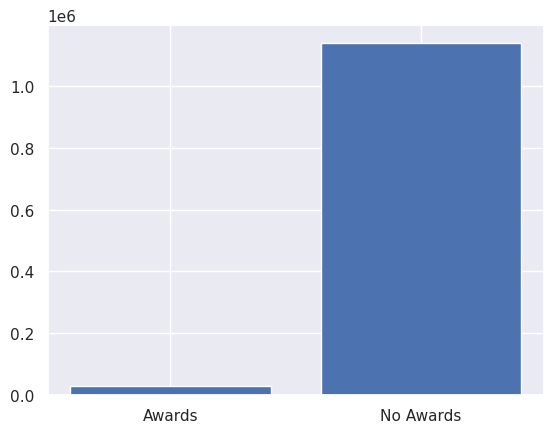

In [18]:
# plot distribution of awards
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# count number of post with awards and without
x1=len(df_post.loc[df_post['award_count'] > 0]) 
x2=len(df_post['award_count']==0)
# plot
plt.bar(['Awards','No Awards'],[x1,x2])
print(x1)
print(x2)


In [15]:
len(df_post.loc[df_post['award_count'] > 0]) 

,author,score,award_count
130,Novicept,54.0,1.0
1507,uneconomist,76.0,1.0
1934,TheTopSnek,73.0,1.0
2107,uvitende,49.0,1.0
2165,_rofl-copter_,95.0,1.0
...,...,...,...
1229064,anooblol,106.0,1.0
1229915,CHAINSAW_VASECTOMY,0.0,4.0
1230251,mikeschinas,-123.0,1.0
1230540,SuperSaiyanSandwhich,98.0,1.0


Sum score done:  2023-01-03 11:41:23.182941
Sum score done
Mean awards done
Sum awards done
Degree done
Betweenness done
Degree Centrality done
Closeness done
Eigenvector done
Clustering done
Average Neighbor Degree done
Metrics calculated


In [82]:
df_nodes

,Average Neighbor Degree,Clustering Coefficient,Eigenvector Centrality,Closeness Centrality,Degree Centrality,Betweenness Centrality,degree,mean_score,sum_score,mean_awards,sum_awards
theycallme1,4.076923,0.006154,2.372364e-01,0.298238,0.096654,0.217544,26,3.525000,141.0,0.0,0.0
DeltaModz,8.071429,0.054945,2.250245e-01,0.304220,0.052045,0.166671,14,1.739130,40.0,NaN,NaN
fatbrownjesus2,15.166667,0.200000,1.456671e-01,0.277214,0.022305,0.033818,6,1.750000,14.0,NaN,NaN
sriram88,11.777778,0.138889,2.008601e-01,0.290090,0.033457,0.051272,9,3.200000,16.0,NaN,NaN
HMG-CoAReductase,9.000000,0.000000,2.588573e-02,0.218913,0.003717,0.000000,1,1.000000,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Aidtor,3.000000,0.000000,6.633146e-03,0.186268,0.007435,0.006603,2,1.500000,3.0,NaN,NaN
mike1234567654321,2.000000,0.000000,5.013424e-14,0.004957,0.003717,0.000000,1,14.714286,103.0,0.0,0.0
treycartier91,2.000000,0.000000,8.549164e-04,0.154097,0.003717,0.000000,1,2.750000,11.0,NaN,NaN
gayweatherthrow,1.000000,0.000000,9.343264e-16,0.003717,0.003717,0.000000,1,12.000000,24.0,0.0,0.0
